## Eye Moisture Evaluation
----------------------

This pipline estimates eye moisture from a cropped video of the subject's eyes based on the average brightness and diameter of the catchlights.

We use numpy and cv2 for computer vision, csv and pandas for data analysis and PIL, matplotlib and seaborn for visualization:

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
#%matplotlib notebook
import numpy as np
import csv
import cv2
from cv2 import __version__
print __version__
import pandas as pd
import seaborn


3.2.0


We use computer vision to locate the area of the image occupied by catchlights by first reducing each pixel to black or white based on a brightness threshold. We then assume the two largest black shapes would include the pupils, and label any white shapes within them as catchlights.

In [2]:
def find_catchlights(image, threshold):
    #thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,thresh1 = cv2.threshold(gray,threshold,255,cv2.THRESH_BINARY)
    #we use erosion and dilation to remove noise
    morphKernel = np.ones((10, 10), np.uint8)
    morph = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, morphKernel)
    #find contours
    _, contours, hierarchy = cv2.findContours(morph.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #find catchlights using hierarchy
    largest = [1,2]
    catchlights = []
    for i in range(3,len(contours)):
        if (cv2.contourArea(contours[i]) > cv2.contourArea(contours[largest[0]])):
            largest[1] = largest[0]
            largest[0] = i
        elif (cv2.contourArea(contours[largest[0]]) > cv2.contourArea(contours[i]) > cv2.contourArea(contours[largest[1]])):
            largest[1] = i
    for i in range(0,len(contours)):
        if (hierarchy[0][i][3] == largest[0])or(hierarchy[0][i][3] == largest[1]):
            catchlights.append(contours[i])
    pupils = [contours[largest[0]],contours[largest[1]]]
    return catchlights, pupils


We measure the average brightness of the catchlight areas as a metric for moisture.

In [3]:
def get_brightness(image,contours):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = np.zeros(gray.shape,np.uint8)
    cv2.drawContours(mask,contours,-1,255,-1)
    pixelpoints = np.transpose(np.nonzero(mask))
    return cv2.mean(gray,mask = mask)[0],pixelpoints.size

We label blink frames and other irregular frames based on the amount of catchlights detected. 

In [4]:
def check_blink(catchlights,blink_range):
    #simple method
    if (len(catchlights) <= blink_range[0]) or (len(catchlights) >= blink_range[1]):
        return True
    return False

We apply our measurement for each image in a video and output a csv file for analysis. The threshold value might require adjustment for darker skins, to ensure the catchlights are properly detected. The blink range can be adjusted based on lighting conditions.

In [5]:
def process_video(video_name,threshold=45,blink_range=[2,6]):
    vidcap = cv2.VideoCapture('videos/' + video_name + ".mov")
    with open(video_name + '.csv', 'wb') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(["frame","brightness","size","catchlights","blink"])
        for i in range(int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))):
            success,frame = vidcap.read()
            if success == False: break
            catchlights,_ = find_catchlights(frame,threshold)
            bright,size = get_brightness(frame,catchlights)
            #check for blinking (simple method)
            blink = 0
            if check_blink(catchlights,blink_range):
                blink = 1
            filewriter.writerow([i,bright,size,len(catchlights),blink])    

# Example Frame

We print a sample frame, and draw the detected contours for the catchlights in green, and for the pupils in blue or red depending on whether a blink was detected. We also print the measured brightness.

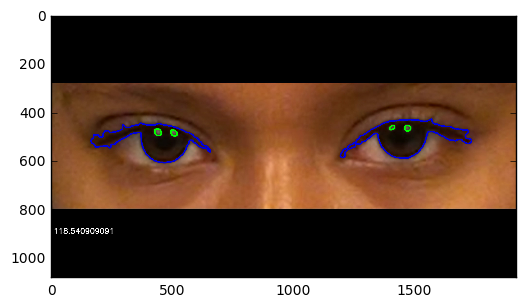

In [6]:
frame = cv2.imread('SampleFrames/frame15.jpg', cv2.IMREAD_COLOR)
catchlights,pupils = find_catchlights(frame, 45)

#draw contours
cv2.drawContours(frame, catchlights, -1, (0, 255, 0), 5)
if check_blink(catchlights,[2,6]): cont_color = (0,0,225)
else: cont_color = (225,0,0)
cv2.drawContours(frame, pupils, -1, cont_color, 5)
cv2.putText(frame,str(get_brightness(frame,catchlights)[0]),(10,900), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()

We can make a video visualization by repeating the visualization process for each frame and outputting a video:

In [7]:
def demo_video(video_name):
    out = cv2.VideoWriter('videos/' + video_name + "_out.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10, (1920,1080))
    cap = cv2.VideoCapture('videos/' + video_name + ".mov")
    for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        success,frame = cap.read()
        if success == False: break
        catchlights,pupils = find_catchlights(frame,45)
        #draw catchlights
        cv2.drawContours(frame, catchlights, -1, (0, 255, 0), 5)
        #draw iris, in red when blinking
        if check_blink(catchlights): cont_color = (0,0,225)
        else: cont_color = (225,0,0)
        cv2.drawContours(frame, pupils, -1, cont_color, 5)
        #write brightness
        cv2.putText(frame,str(i) + ", " + str(get_brightness(frame,catchlights)),(10,900), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
        #write to output
        out.write(frame)
    cap.release()
    out.release()

# Analysis

Each video yeilds a csv file that's easy to work with:

In [8]:
video_name = "2012-07-16-13.25.47_1"
Data = pd.read_csv(video_name + ".csv", sep=',', decimal='.', header=0)
Data.head()

,frame,brightness,size,catchlights,blink
0,0,72.921383,5902,5,0
1,1,73.590811,5572,5,0
2,2,72.789310,5800,5,0
3,3,74.635738,5518,5,0
4,4,75.867102,5508,5,0


When plotting brightness over time, the impact of blinks is noticable:

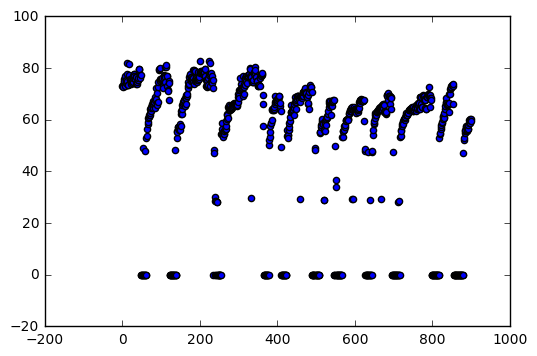

In [9]:
plt.scatter(Data["frame"], Data["brightness"])
plt.show()

Our blink seems to label blinks correctly, but also some other frames:

In [10]:
fg = seaborn.FacetGrid(data= Data, hue='blink', hue_order= [1,0], aspect = 2)
fg.map(plt.scatter, 'frame', 'brightness').add_legend()

We gain an insight into this by plotting catchlight size over time, and noticing abnormal frames. It seems that in some extreme conditions, our catchlight identification fails, and a larger area is counted as a catchlight. The upper bound on the catchlight-count on our blink detection compensates for the effect.

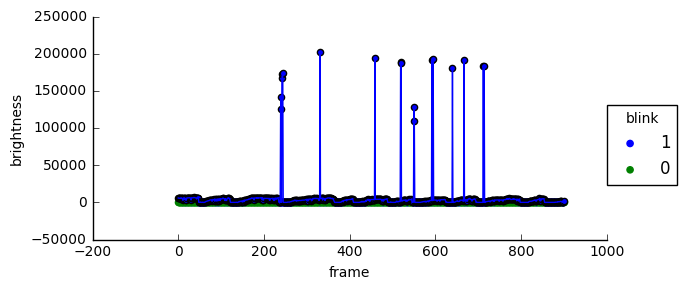

In [11]:
plt.plot(Data["frame"], Data["size"])
plt.scatter(Data["frame"], Data["size"])
plt.show()

So, we eliminate blinking frames from our analysis, only to find the periodic fluctuation still enduring as a significant effect. We graph catchlight brightness and size over time again, and then against each other.

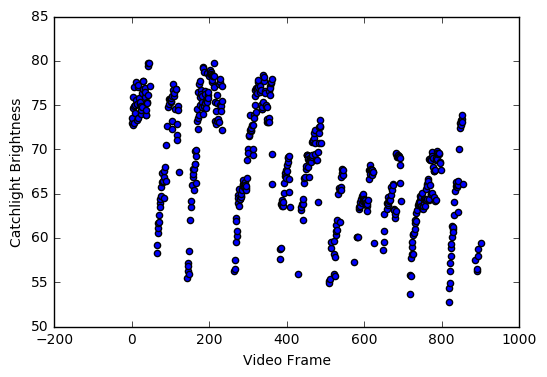

In [12]:
no_blink_data = Data[Data.blink != 1]
plt.scatter(no_blink_data["frame"], no_blink_data["brightness"])
plt.xlabel("Video Frame")
plt.ylabel("Catchlight Brightness")
plt.show()

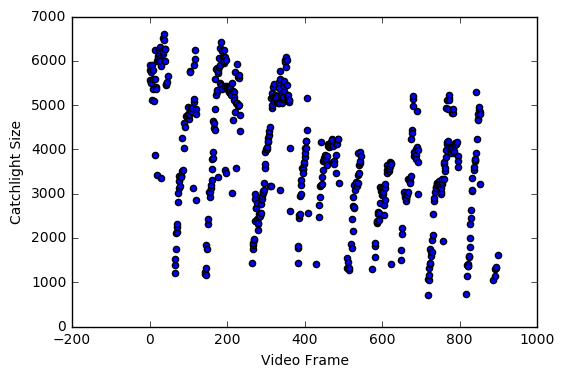

In [13]:
plt.scatter(no_blink_data["frame"], no_blink_data["size"])
plt.xlabel("Video Frame")
plt.ylabel("Catchlight Size")
plt.show()

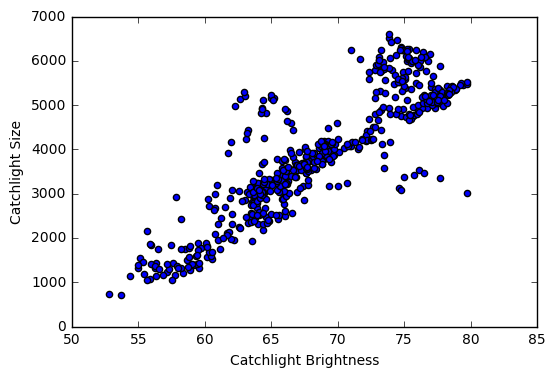

In [14]:
plt.scatter(no_blink_data["brightness"], no_blink_data["size"])
plt.xlabel("Catchlight Brightness")
plt.ylabel("Catchlight Size")
plt.show()

The correlation we observe is understandable due to the nature light and of our algorithm that defines catchlights based on a gradient in brightness. Specular highlights such as catchlights have a percieved diameter that depends on the lightning conditions and the reflectivity of the material.

Since our lighting conditions are constant, we conclude that the catchlight brightness and size measurements correlate with a gradual increase in reflectivity in the eye following each blink. While manually confirming that the eye has already fully opened before the brightness fluctuation reaches its peak, we have observed the effect for ourselves, as catchlights gradually grow back after each blink. We believe this change in reflectivity is due to a re-moisturization of the tear film, confirming our underlying assumption that we can infer eye moisture from the properties of catchlights.

This fluctuation behavior means that a global mean-brightness metric is prone to correlation with blinking frequency. This also makes sense if people tend to blink more with drier eyes, but since blinking frequency was not explicitly states as a factor to examine, we should compensate for the effect. We do this in two steps: We determine true blinks by defining them as a few consequtive blink frames, and then we discard a few frames following a blink frame.

In [25]:
def wide_open(no_blink_data,true_blink_threshold,margin):
    to_erase=[]
    prev=0
    #mark true blinks
    for index,row in no_blink_data.iterrows():
        if (row["frame"]-prev) >= true_blink_threshold:
            to_erase.append("1")
        else: to_erase.append("0")
        prev = int(row["frame"])
    #mark margin
    for i in range(margin,len(to_erase)):
        if to_erase[-i] == "1":
            for j in range(margin):
                to_erase[-(i-j)] ="1"
    #erase
    no_blink_data.insert(0,"erase",to_erase)
    wide_open_data = no_blink_data[no_blink_data.erase != "1"]
    return wide_open_data

(540, 5)
(540, 6)
(171, 6)


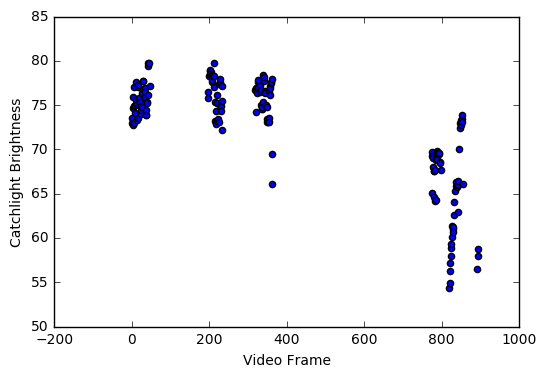

In [39]:
no_blink_data = Data[Data.blink != 1]
wide_open_data = wide_open(no_blink_data,5,50)
plt.scatter(wide_open_data["frame"], wide_open_data["brightness"])
plt.xlabel("Video Frame")
plt.ylabel("Catchlight Brightness")
plt.show()

Now that we've cleared up our data, we can extract mean and maximum brightness level for each video to evaluate eye moisture.